#Configuración del ambiente de trabajo

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')



Mounted at /content/gdrive/


In [ ]:
my_folder_path = '/content/gdrive/MyDrive/MySavedModels/'
generated_plots_folder_path = 'GeneratedPlots/'
generated_models_folder_path = 'GeneratedModels/'
chapter_07_path = 'Chapter_07/'
chapter_10_path = 'Chapter_10/'


full_chapter_07_path = my_folder_path+chapter_07_path
full_model_chapter_07_path = my_folder_path+chapter_07_path
full_plot_chapter_07_path = my_folder_path+chapter_07_path

full_mnist_discriminator_00_path = my_folder_path+'Discriminator_model_00/'
full_mnist_discriminator_01_path = my_folder_path+'Discriminator_model_01/'

In [ ]:
from os import makedirs

# make folder for results
makedirs(full_model_chapter_07_path, exist_ok=True)
makedirs(full_plot_chapter_07_path, exist_ok=True)
makedirs(full_mnist_discriminator_00_path, exist_ok=True)
makedirs(full_mnist_discriminator_01_path, exist_ok=True)


In [ ]:
import numpy as np

np.random.seed(0)

##Funciones auxiliares

In [ ]:
def save_into_my_models(model, model_name):
  model.save(model_name)
  print('Saving file {}'.format(model_name))

In [ ]:
from math import floor

# To save the time training of the model
def rec_time_exec(model_path, start_time, i):
  end_time = time.time()
  elapsed_time = end_time - start_time
  elapsed_time_minutes = floor(elapsed_time) // 60
  elapsed_time_hours =  floor(elapsed_time_minutes) // 60
  elapsed_time_rem_mins = elapsed_time_minutes % 60
  elapsed_time_rem_secs = elapsed_time % 60
  time_txt_file = model_path +'training_time_%03d.txt' % (i+1)
  with open(time_txt_file, 'w') as file:
    file.write(f"Training time: {round(elapsed_time)} seconds = {elapsed_time_hours} hrs: {elapsed_time_rem_mins} mins: {elapsed_time_rem_secs} secs")


In [ ]:
# To create folders organized by epochs and batch_size parameters
def create_local_folders(model_path, n_epochs, n_batch):
  full_model_path = model_path + 'epochs_'+ str(n_epochs) + '/batchsize_'+str(n_batch)+'/'+generated_models_folder_path
  full_plot_path = model_path + 'epochs_'+ str(n_epochs) + '/batchsize_'+str(n_batch)+'/'+generated_plots_folder_path
  makedirs(full_model_path, exist_ok=True)
  makedirs(full_plot_path, exist_ok=True)
  return (full_model_path, full_plot_path)

#Aplicación de modelos al conjunto de datos MNIST

**ref: Chapter 7 from book Generative Adversarial Networks with Python - Deep Learning Generative Models for Image Synthesis and Image Translation**

En esta sección se verá en detalle paso a paso cómo implementar redes neuronales para tareas de clasificación, así como la implementación de redes neuronales adversarias (GANs) para la generación de dígitos manuscritos utilizando el conocido conjunto de datos MNIST.   

La sección comienza presentando una descripción de la interfaz de programación de aplicaciones (API por su siglas en inglés Application Programming Interface) que se utilizará para la implementación de los diversos modelos y para el desarrollo de pruebas y evaluación de los mismos.    

La siguiente sección presenta una breve descripción sobre el conjunto de datos MNIST que serán utilizados para el entramiento y evaluación de los modelos generados.    

Luego se presenta una sección donde se implementa un clasificador de imágenes a a partir del conjunto MNIST. La tarea principal será determinar a partir de una imagen de 28X28, qué número le corresponde.   

En la siguiente sección se verá la primera aplicación que utilizará una red neuronal adversaria convolucional también conocida como una DCGAN, en donde tanto el discriminador como el generador se implementan como redes neuronales de convolución.    

En la siguiente sección se presenta una red neuronal adversaria modificada aplicando criterios que generen una GAN que presenta características más estables respecto al primer modelo.    

De cada modelo, se verá en detalle la implementación de cada componente del modelo, su forma de entramiento, evaluación y resultados obtenidos mediante la generación de imágenes a través del generador de cada modelo.

##Interfaz de Programación de Aplicaciones KERAS

**ref: Chapter 7 from book Generative Adversarial Networks with Python - Deep Learning Generative Models for Image Synthesis and Image Translation**

Keras es una API de alto nivel de la plataforma TensorFlow. Proporciona una interfaz para resolver problemas de aprendizaje automático (ML), con un enfoque en el aprendizaje profundo permitiendo el diseño de redes neuronales de forma sencilla y eficiente.   
Keras está escrito en el lenguaje de programación Python y permite implementar todo el ciclo de vida del desarrollo de modelos de aprendizaje profundo como las redes neuronales.   
En el ciclo de vida del desarrollo de una red neuronal encontramos las siguientes etapas de: Definición, compilación, ajuste y evaluación de un modelo. Así mismo KERAS nos permitirá hacer predicciones a través de los modelos que desarrollemos.




##El conjunto de datos MNIST

**ref: Chapter 7 from book Generative Adversarial Networks with Python - Deep Learning Generative Models for Image Synthesis and Image Translation**

El conjunto de datos MNIST es un acrónimo que significa Instituto Nacional Modificado de Estándares y Tecnología (Modified National Institute of Standards and Technology).   
Es un conjunto de datos de 70.000 imágenes cuadradas pequeñas en escala de grises de 28 × 28 píxeles de
dígitos únicos escritos a mano entre 0 y 9.   
Keras proporciona acceso al conjunto de datos MNIST a través de la función mnist.load dataset(). Devuelve dos tuplas, uno con los elementos de entrada y salida para el conjunto de datos de entrenamiento estándar, y otro con los
elementos de entrada y salida para el conjunto de datos de prueba estándar. Este conjunto permitirá el diseño de modelos tanto para tareas de clasificación como también el diseño de una GAN para generar imágenes de dígitos manuscritos.  

El siguiente ejemplo carga el conjunto de datos y resume la forma del conjunto de datos cargado.    


**Listing 7.1: Example of loading and summarizing the MNIST dataset.**

In [ ]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


Aquí se aprecia la estructura del conjunto de datos, donde cada elemento es una imagen de 28x28 y se separa el conjunto total de datos en dos subconjuntos de 60.000 y 10.000 para el conjunto de entrenamiento y el conjunto de pruebas respectivamente.  


Las imágenes están en escala de grises con un fondo negro (valor de 0 píxeles) y los dígitos escritos a mano en blanco (valores de píxeles cercanos a 255).   

Esto significa que si las imágenes fueran trazadas, serían en su mayoría
negro con un dígito blanco en el medio. Podemos trazar algunas de las imágenes del conjunto de datos de entrenamiento usando la función imshow() de la biblioteca Matplotlib usando y especificando el mapa de color a través del
argumento cmap como "gris" para mostrar los valores de píxeles correctamente.  
A continuación se presenta una muestra de la imágenes del conjunto MNIST.

**Listing 7.5: Example of plotting images from the MNIST dataset.**

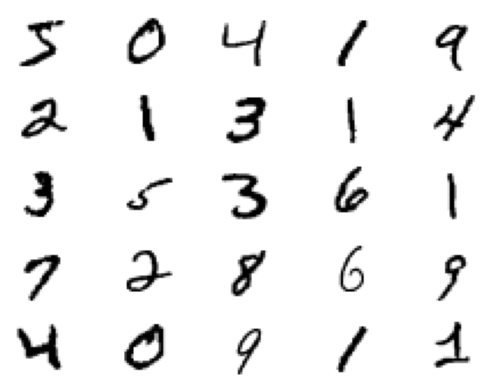

<Figure size 640x480 with 0 Axes>

In [ ]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
from matplotlib import pyplot
from os import makedirs

# create folder if it does not exist
makedirs(full_mnist_discriminator_00_path+generated_plots_folder_path, exist_ok=True)

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()
pyplot.savefig(full_mnist_discriminator_00_path+generated_plots_folder_path+'mnist_samples_plot.png')

Podemos ver también una muestra de imágenes junto a sus correspondientes etiquetas.

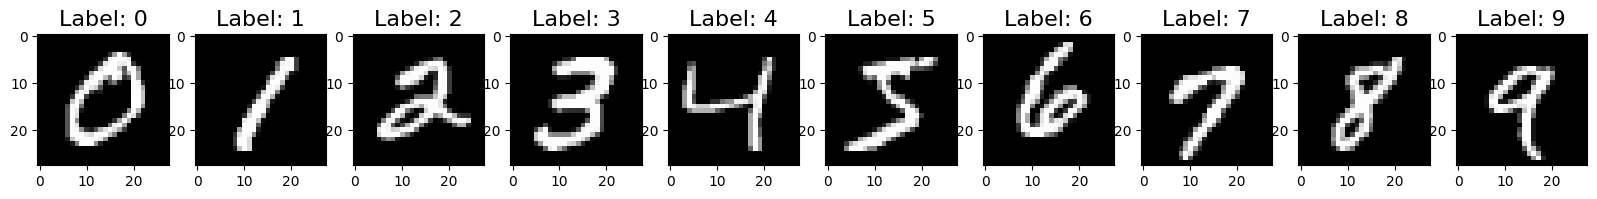

In [ ]:
import matplotlib.pyplot as plt

num_classes = 10
f, ax = plt.subplots(1, num_classes, figsize=(20,20))
# check this function on the web

for i in range(10):
  sample = trainX[trainy==i][0]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Label: {}".format(i), fontsize=16)
f.savefig(full_mnist_discriminator_00_path+generated_plots_folder_path+'mnist_samples_and_labels_plot.png')

## Clasificador de dígitos manuscritos

En la presente sección se implementa un clasificador de imágenes a a partir del conjunto MNIST. La tarea principal será determinar a partir de una imagen de 28X28, qué número le corresponde.   
Para ello utilizaremos una red neuronal más simple mediante dos capas densas totalmente conectadas.   
Luego intentaremos mejorar los resultados con una segunda red neuronal que utilice capas de convolución y de pooling.
Finalmente haremos una breve comparación de resultados.

### Diseño del Clasificador de Dígitos Simple

#### Preparación del conjunto de datos

**Categorización de datos**   
Nuestro modelo deberá clasificar entre 10 categorías que representarán cada uno de los 10 dígitos existentes, es decir que una categoría represetará al número 0, otra al 1 y así sucesívamente hasta el dígito 9.   
Para ello utilizaremos el proceso de transformación denominado "One hot enconding" de modo de hacer una conversión de información categórica a un formato que pueda incorporarse en nuestro modelo.  


El conjunto de datos MNIST está dado en parejas (X,Y) donde X representa la imagen e Y su correpondiente etiqueta que indica el número al que corresponde al imagen.   
A continuación se presenta una muestra de las etiquetas y luego se verá como quedan representados mediante la transformación de "One hot encoding".   

In [ ]:
#showing the first 10 elements

for i in range(10):
  print(trainy[i])

5
0
4
1
9
2
1
3
1
4


Si se transforman los números anteriores mediante "One hot encoding" obtenemos los siguientes vectores:

In [ ]:
import keras

# transforming numbers into classes using one hot encoding
num_classes = 10
trainy = keras.utils.to_categorical(trainy, num_classes) # numclasses is defined in previous code block
testy = keras.utils.to_categorical(testy, num_classes)


In [ ]:
for i in range(10):
  print(trainy[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Aquí se aprecia que cada elemento es un vector de 10 posiciones (de 0 a 9)donde todos los elementos están en 0 y en 1 la posición correspondiente al número de la etiqueta. Por ejemplo, el primer elemento tiene en 1 el elemento de la posición 5 (recordar que el primer elemento es la posición 0) y corresponde al número 5.  
El segundo vector tiene en 1 la posición 0 que corresponde al número 0, el tercer vector tiene un 1 en la posición 4 y así sucesivamente.

**Escalar los datos entre 0 y 1**   
Los modelos presentan mejores características de eficiencia cuando los datos están en una escala acotada. Por lo que a continuación transformaremos el valor de cada píxel de cada imagen de una escala de 0 a 255 a otra escala entre 0 y 1.  

In [ ]:
# we start normalizing data
trainX = trainX / 255.0
testX = testX / 255.0


**Aplanar el conjunto de datos**    
Dado que nuestro primer modelo será una red conteniendo dos capas densas, deberemos aplanar el conjunto de datos de modo de ingresar cada imagen como un vector de píxeles.   Por lo que a continuación se hará una transformación de cada imagen representada por una matriz de 28x28 a un vector de 784 elementos.

In [ ]:
# reshape the images into 1 dimension array. So we will have one array of length 28*28
x_train_flat = trainX.reshape(trainX.shape[0], -1)
x_test_flat = testX.reshape(testX.shape[0], -1)

print("x_train_flat.shape: {}, x_test_flat.shape: {}".format(x_train_flat.shape, x_test_flat.shape))

x_train_flat.shape: (60000, 784), x_test_flat.shape: (10000, 784)


####Diseño del clasificador

El clasificador será una red neuronal que consta de dos capas de 128 nodos cada una. La función de activación será ReLu a la salida de cada capa.   
Entre cada una de las capas se utiliza una capa de Dropout a efectos de mejorar la capacidad de generalización del modelo.   
La capa de salida se implementará de 10 nodos y utilizará la función "softmax" utilizada en casos de clasificación de más de dos categorías.  
La función de pérdida "categorical_crossentropy" dado que se trata de una clasificación de más de dos categorías, "Accuracy" como métrica y el optimizador "Adam".  


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(units=128, input_shape=(784,), activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.25)) # this means that 0.25 of neurons are deactivated during training
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Estructura del modelo**    
A continuación se presenta el diseño del modelo.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


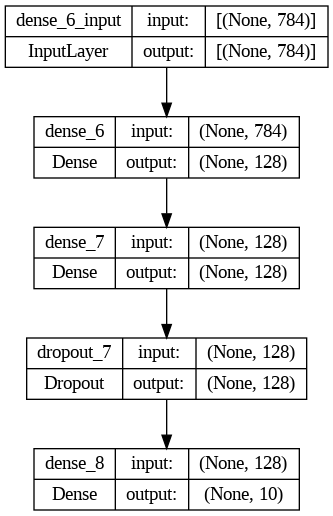

In [ ]:
from os import makedirs
from keras.utils import plot_model

# make folder for results
makedirs(full_mnist_discriminator_00_path+generated_models_folder_path, exist_ok=True)
makedirs(full_mnist_discriminator_00_path+generated_plots_folder_path, exist_ok=True)

def myprint(s):
    with open(full_mnist_discriminator_00_path+generated_models_folder_path+'modelsummary_00.txt','a') as f:
        print(s, file=f)
model.summary(print_fn=myprint)
model.summary()
plot_model(model, to_file=full_mnist_discriminator_00_path+generated_plots_folder_path+'model_00_simple_discriminator_plot.png', show_shapes=True, show_layer_names=True)


#### Entrenamiento del clasificador

Utilizaremos un tamaño de lote de 512 imágenes por lote. Este hiper-parámetro puede variarse y su valor afecta el resultado del entrenamiento. Por lo que se variar el tamaño de lote puede afectar aprendizaje y por lo tanto la performance de un mismo modelo.
Comenzaremos con un tamaño de 512 y en el siguiente modelo tomaremos un tamaño menos que junto a otras modificaciones intentaremos mejorar los resultados obtenidos.

In [ ]:
batch_size = 512  # This means that we are using 512 images at a single time before updating the weights with forward and backpropagation
num_epochs = 10

In [ ]:
from os import makedirs
(complete_model_path, complete_plot_path) = create_local_folders(full_mnist_discriminator_00_path, num_epochs, batch_size)

In [ ]:
print(complete_model_path)

/content/gdrive/MyDrive/MySavedModels/Discriminator_model_00/epochs_10/batchsize_512/GeneratedModels/


In [ ]:
import time
start_time = time.time()
model.fit(x=x_train_flat, y=trainy, batch_size=batch_size,epochs=num_epochs)
rec_time_exec(complete_model_path, start_time, num_epochs)


Epoch 1/10
118/118 [==============================] - 1s 5ms/step - loss: 0.5994 - accuracy: 0.8237
Epoch 2/10
118/118 [==============================] - 0s 4ms/step - loss: 0.2303 - accuracy: 0.9328
Epoch 3/10
118/118 [==============================] - 0s 4ms/step - loss: 0.1682 - accuracy: 0.9509
Epoch 4/10
118/118 [==============================] - 0s 3ms/step - loss: 0.1330 - accuracy: 0.9614
Epoch 5/10
118/118 [==============================] - 0s 4ms/step - loss: 0.1097 - accuracy: 0.9676
Epoch 6/10
118/118 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.9725
Epoch 7/10
118/118 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9754
Epoch 8/10
118/118 [==============================] - 0s 4ms/step - loss: 0.0723 - accuracy: 0.9783
Epoch 9/10
118/118 [==============================] - 0s 4ms/step - loss: 0.0622 - accuracy: 0.9811
Epoch 10/10
118/118 [==============================] - 0s 4ms/step - loss: 0.0560 - accuracy: 0.9832

**Guardar el modelo**

Entrenar un modelo requiere de esfuerzo computacional y tiempo de ejecución. En ocasiones requiere de varias horas. Por lo que a efectos de no perder los parámetros calculados de un modelo luego de su entrenamiento, conviene guardar el modelo. Esto nos permitirá utilizarlo en el futuro sin la necesidad de volver a ejecutar la tarea de entrenamiento.  

In [ ]:
save_into_my_models(model, complete_model_path+'generator_model_%03d.h5' % num_epochs)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saving file /content/gdrive/MyDrive/MySavedModels/Discriminator_model_00/epochs_10/batchsize_512/GeneratedModels/generator_model_010.h5


Probamos que se haya guardado el modelo correctamente.

In [ ]:
from keras.models import load_model
reloaded_model = load_model(complete_model_path+'generator_model_%03d.h5' % num_epochs)

reloaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Evaluación del clasificador

Para evaluar el modelo se observará el nivel de precisión del mundo frente a un nuevo conjunto de datos no utilizado previamente para su entrenamiento. Es decir, el conjunto de pruebas.   
El conjunto de pruebas consta de 10.000 imágenes de 28x28, cada una de ellas con su respectiva etiqueta que indica el número al que corresponde la imagen.  

In [ ]:
test_loss, test_acc = reloaded_model.evaluate(x_test_flat, testy)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

313/313 [==============================] - 1s 3ms/step - loss: 0.0723 - accuracy: 0.9763
Test Loss: 0.07226943969726562, Test Accuracy: 0.9763000011444092


Se obtuvo un nivel de precisión de 97,90 %.

####Predicciones a través del clasificador

Una vez evaluado el modelo, podemos utilizarlo para realizar predicciones a partir de nuevos datos de entrada.   
A continuación se muestra el formato de las salidas de predicción del modelo.



In [ ]:
import numpy as np

y_pred = reloaded_model.predict(x_test_flat)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred)
print(y_pred_classes)

313/313 [==============================] - 1s 2ms/step
[[2.7131791e-06 2.1080916e-07 5.5034438e-05 ... 9.9964714e-01
  5.9239919e-06 2.4304123e-05]
 [8.5486612e-08 4.3879802e-05 9.9992955e-01 ... 5.6364613e-10
  6.5548835e-07 8.0921190e-12]
 [1.1653834e-06 9.9875522e-01 2.5517485e-04 ... 7.3905138e-04
  1.1653502e-04 1.1408817e-06]
 ...
 [2.5523539e-10 2.9663010e-09 6.8873511e-09 ... 7.1977597e-06
  5.5863200e-07 1.1431879e-05]
 [3.3305444e-08 5.1483562e-07 1.1364413e-09 ... 5.2375235e-08
  4.7843147e-05 4.6201151e-08]
 [3.1112651e-07 2.1391571e-09 6.5480648e-08 ... 2.9996611e-12
  1.5201312e-08 2.0100657e-09]]
[7 2 1 ... 4 5 6]


Aquí se observa que para elemento del conjunto de prueba, se devuelve un vector con una probabilidad asociada a cada posición.
La predicción será el número correspondiente a la posición con la mayor probabilidad asignada.    
Veamos a continuación un número seleccionado al azar junto al número de predicción y su etiqueta con el número real correspondiente a la imagen.

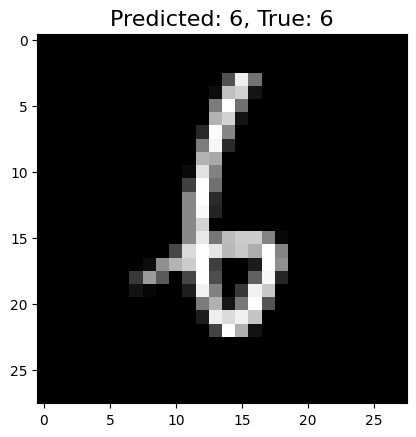

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_idx = np.random.choice(len(x_test_flat))
x_sample = x_test_flat[random_idx]
y_true = np.argmax(testy, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred_classes[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.reshape(28, 28), cmap='gray')

**Matriz de confusión del modelo**    
Si bien conocemos a nivel global el nivel de precisión del modelo, no se conoce el nivel de precisión para un dígito específico. Es posible que el modelo tenga un nivel de precisión diferente frente a distintos dígitos.  Para ello, se presenta a continuación una matriz de confusión a efectos de realizar este estudio.   

In [ ]:
print(complete_model_path)
print(complete_plot_path)

/content/gdrive/MyDrive/MySavedModels/Discriminator_model_00/epochs_10/batchsize_512/GeneratedModels/
/content/gdrive/MyDrive/MySavedModels/Discriminator_model_00/epochs_10/batchsize_512/GeneratedPlots/


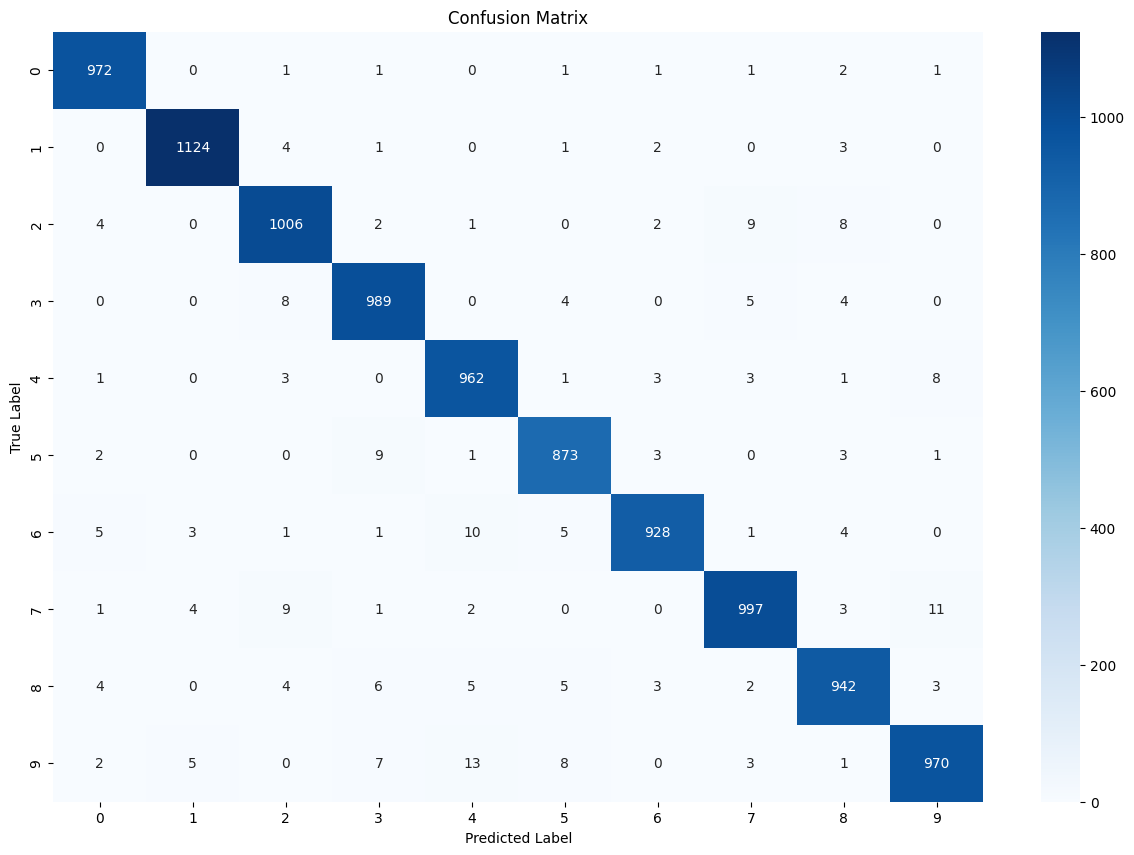

In [ ]:
from sklearn.metrics import confusion_matrix  # check what this is
import seaborn as sns

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax,cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
fig.savefig(complete_plot_path+'confusionMatrix_model.png')

En la matriz anterior, si por ejemplo vemos la primera fila que corresponde al nro 0, tenemos que:
* 972 elementos fueron correctamente evaluados en 0.
* 0 elementos fue     evaluado como 1 cuando eran 0.
* 1 elemento  fue    evaluado  como 2 cuando era un 0.
* 1 elemento  fue    evaluado  como 3 cuando era un 0.
* 0 elemento  fue    evaluado  como 4 cuando eran 0.
* 1 elemento  fue    evaluado  como 5 cuando era un 0.
* 1 elemento  fue    evaluado  como 6 cuando era un 0.
* 1 elemento  fue    evaluado  como 7 cuando era un 0.
* 2 elementos fueron evaluados como 8 cuando eran un 0.
* 1 elemento fue evaluados como 9 cuando eran un 0.

**Análisis de errores de predicción**    
Una vez obtenida la matriz de confusión, se cuenta con información suficiente para conocer la precisión del modelo ante cada los diferentes dígitos del conjunto de prueba.  
Para completar el análisis, nos resultó de interés poder observar las imágenes en las que el modelo se equivocó con mayor probabilidad. En otras palabras, nos referimos a aquellas que confundieron más al modelo.

In [ ]:
errors = (y_pred_classes - y_true !=0)
y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_test_errors = x_test_flat[errors]

In [ ]:
y_pred_errors_probability = np.max(y_pred_errors, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
diff_errors_pred_true = y_pred_errors_probability - true_probability_errors

# Get list of indices of sorted differences
sorted_idx_diff_errors = np.argsort(diff_errors_pred_true)
top_idx_diff_errors = sorted_idx_diff_errors[-5:] #

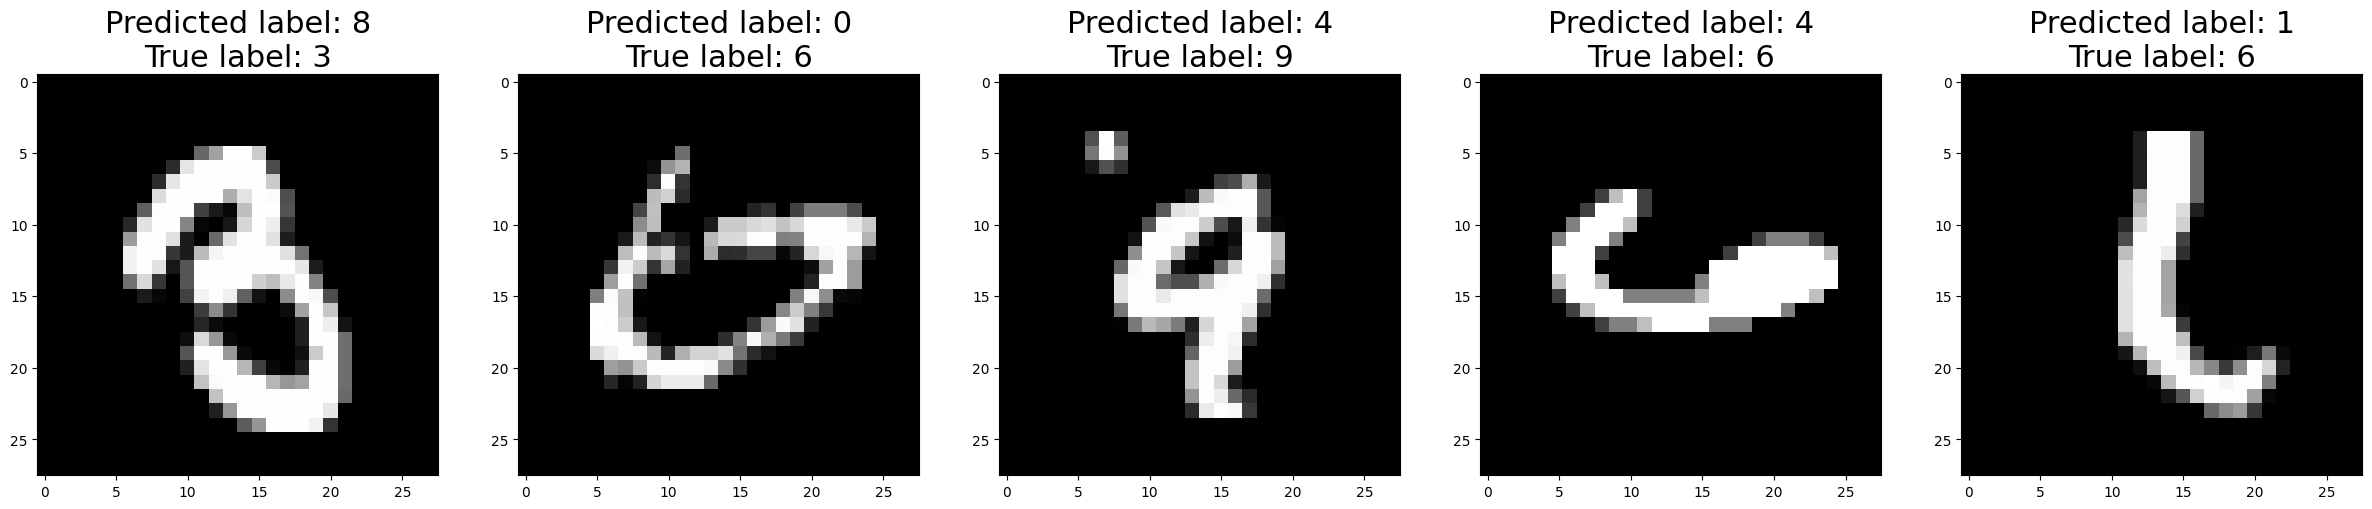

In [ ]:
num = len(top_idx_diff_errors)
f, ax = plt.subplots(1, num, figsize=(30,30))

for i in range(0, num):
  idx = top_idx_diff_errors[i]
  sample = x_test_errors[idx].reshape(28,28)
  y_t = y_true_errors[idx]
  y_p = y_pred_classes_errors[idx]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Predicted label: {}\nTrue label: {}".format(y_p, y_t), fontsize=22)

f.savefig(complete_plot_path+'errors_model.png')


Observando las imágenes anteriores se puede decir que:
* Se trata de casos que no son del todo claros y es razonable que el modelo se equivoque.  
* La primera y la tercera corresponden al número 7, pero son imágenes que también podrían corresponder al número 2, dado que que la línea horizontal que habitualmente vemos en el medio del número 7, en estos casos se encuentra en una posición inferior como suele verse en el número 2.  
* La segunda imagen es posible que se confunda el modelo dado que es un 3 manuscrito atípico y que también podría interpretarse como un un 7 debido a su forma.  
* La cuarta imagen es posible que confunda a la propia interpretación de un ser humano.  
* La imagen más clara es la última que corresponde a un 9, pero tiene un píxel atípico que podría haber afectado la clasificación del modelo.

###Diseño del Clasificador de Dígitos con Capas de Convolución

####Preparación del conjunto de datos

**Categorización de datos**   
Al igual que en el caso anterior, nuestro modelo deberá clasificar entre 10 categorías que representarán cada uno de los 10 dígitos existentes, es decir que una categoría represetará al número 0, otra al 1 y así sucesívamente hasta el dígito 9.   
Para ello, como en el caso anterior se utiliza el proceso de transformación denominado "One hot enconding" de modo de hacer una conversión de información categórica a un formato que pueda incorporarse en nuestro modelo.  


In [ ]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

Recordemos el formato de las etiquetas luego de la aplicación del procesao de transformación de "One hot encoding".
Se observan los siguientes vectores:

In [ ]:
import keras

# transforming numbers into classes using one hot encoding
num_classes = 10
trainy = keras.utils.to_categorical(trainy, num_classes) # numclasses is defined in previous code block
testy = keras.utils.to_categorical(testy, num_classes)


In [ ]:
for i in range(10):
  print(trainy[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Aquí se aprecia que cada elemento es un vector de 10 posiciones (de 0 a 9) donde todos los elementos están en 0 y en 1 la posición correspondiente al número de la etiqueta. Por ejemplo, el primer elemento tiene en 1 el elemento de la posición 5 (recordar que el primer elemento es la posición 0) y corresponde al número 5.  
El segundo vector tiene en 1 la posición 0 que corresponde al número 0, el tercer vector tiene un 1 en la posición 4 y así sucesivamente.

**Escalar los datos entre 0 y 1**   
Los modelos presentan mejores características de eficiencia cuando los datos están en una escala acotada. Por lo que a continuación transformaremos como en el modelo anterior, el valor de cada píxel de cada imagen de una escala de 0 a 255 a otra escala entre 0 y 1.  

In [ ]:
# we start normalizing data
trainX = trainX / 255.0
testX = testX / 255.0


**Transformación  del conjunto de datos**    
Dado que nuestro segundo modelo recibirá directamente una imagen de 28x28 será necesario en lugar de aplanar los datos como en el modelo anterior, ahora deberemos ajustar los datos para que tengan una dimensión más y queden de 28x28x1. Esto se debe a que la función de Keras que utiliza la operación de Convolución, está preparada para recibir imágenes de colores. Es decir de 28x28x3, por sus formato RBG de canales de colores en imágenes. Por lo que cuando se trata de imágenes en blanco y negro, se debe indicar que el conjunto cuenta con un único canal y por lo tanto, estas deberán estar en un formato de 28x28x1.

In [ ]:
from numpy import expand_dims

trainX = expand_dims(trainX, axis=-1)
print(trainX.shape)

(60000, 28, 28, 1, 1)


####Diseño de un Clasificador con Capas de Convolución

Este segundo clasificador tiene por objetivo mejorar la precisión del modelo anterior.   
En este caso, será una red neuronal que consta de:
* Una capa de convolución de 64 filtros y un kernel de (3,3), seguido de una capa de pooling de (2,2).  
* Una segunda capa de convolución de 64 filtros y un kernel de (3,3), seguido de una capa de pooling de (2,2).
* Una capa de Droput con parámetro 0.25 que permite mejorar la capacidad de generalización del modelo desactivando de forma aleatoria el 25% de las neuronas de la capa anterior inmediata.  
* La operación Flatten() simplemente transforma la salida de la capa anterior a un único vector lineal. Ahora la salida se ve como una tira de neuronas.   
* Una capa densa de 64 nodos. La función de activación será ReLu a la salida de cada capa.   
* Finalmente una capa de salida de 10 nodos que utilizará la función "softmax" utilizada en casos de clasificación de más de dos categorías.  
Para la compilación del modelo se utiliza la función de pérdida "categorical_crossentropy" dado que se trata de una clasificación de más de dos categorías, "Accuracy" como métrica y el optimizador "Adam".  


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, UpSampling2D

model_1 = Sequential()
model_1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Flatten())
model_1.add(Dropout(0.25))
model_1.add(Dense(units=64, activation='relu'))
model_1.add(Dense(units=10, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Estructura del modelo**    
A continuación se presenta el diseño del modelo.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3200)              0         
                                                                 
 dropout_8 (Dropout)         (None, 3200)             

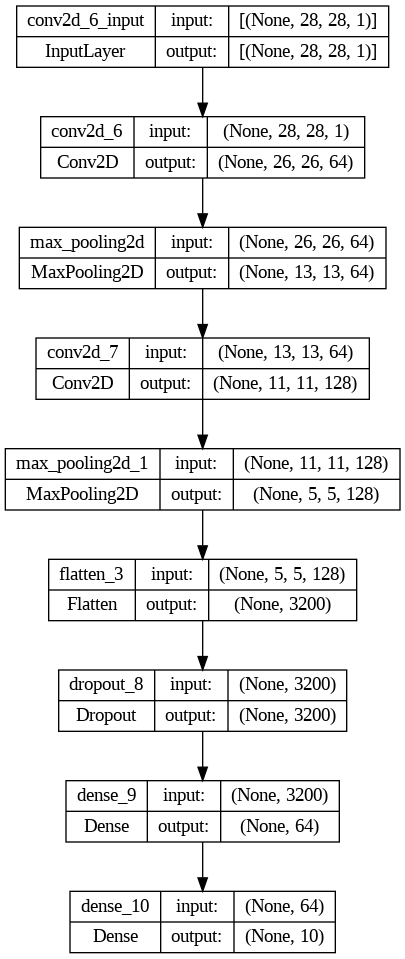

In [ ]:
from os import makedirs
from keras.utils import plot_model

# make folder for results
makedirs(full_mnist_discriminator_01_path+generated_models_folder_path, exist_ok=True)
makedirs(full_mnist_discriminator_01_path+generated_plots_folder_path, exist_ok=True)

def myprint(s):
    with open(full_mnist_discriminator_01_path+generated_models_folder_path+'modelsummary_01.txt','a') as f:
        print(s, file=f)

model_1.summary(print_fn=myprint)
model_1.summary()
plot_model(model_1, to_file=full_mnist_discriminator_01_path+generated_plots_folder_path+'model_01_conv_discriminator_plot.png', show_shapes=True, show_layer_names=True)


**Visualizando algunos filtros de la capa de convolución de Keras en el modelo**   
La operación Conv2D de Keras utiliza distintos filtros predefinidos a efectos de destacar distintas características de una imagen. Esto permite hacer una extracción de características de la imagen como ser los bordes, líneas verticales y horizontales, líneas curvas, etc. Estos elementos mejoras la eficiencia de la red neuronal cuando se pasa toda información a las capas densas del modelo. El entrenamiento de la red permite que se calculen parámetros específicamente asociados a las características obtenidas en las capas anteriores de convolución y pooling, facilitando el aprendizaje de la red y mejorando la eficiencia del modelo.  


A continuación se muestra cómo se ven algunos de los filtros incluidos en la operación Conv2D de Keras.

(3, 3, 1, 64)
f_min: -0.1010403037071228 f_max: 0.10110931098461151


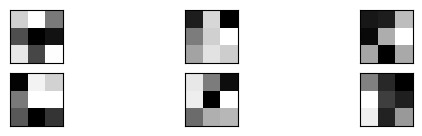

<Figure size 640x480 with 0 Axes>

In [ ]:
# ref: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
from os import makedirs
from matplotlib import pyplot

makedirs(full_mnist_discriminator_01_path+generated_plots_folder_path, exist_ok=True)

# accessing filters of the first layer that has a Con2D layer
filters, _ = model_1.layers[0].get_weights()
print(filters.shape)
f_min, f_max = filters.min(), filters.max()
print("f_min: {} f_max: {}".format(f_min,f_max))
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1

for i in range(n_filters):
 # get the filter
 f = filters[:, :, :, i]
 # plot each channel separately
 for j in range(1):
  # specify subplot and turn of axis
  ax = pyplot.subplot(n_filters, 3, ix)
  ax.set_xticks([])
  ax.set_yticks([])
  # plot filter channel in grayscale
  pyplot.imshow(f[:, :, j], cmap='gray')
  ix += 1
# show the figure
pyplot.show()
pyplot.savefig(full_mnist_discriminator_01_path+generated_plots_folder_path+'filters_01.png')


# Displaying first 10 filters
# for i in range(10):
#   f = filters_normalized[:,:,:,i]
#   f = cv2.resize(f, (250, 250), interpolation=cv2.INTER_NEAREST)
#   cv2_imshow(f)

# cv2.waitKey(0)

####Entrenamiento del clasificador

Utilizaremos un tamaño de lote de 128 imágenes por lote. Este hiper-parámetro puede variarse y su valor afecta el resultado del entrenamiento. Por lo que se variar el tamaño de lote puede afectar aprendizaje y por lo tanto la performance de un mismo modelo.
Recordemos que en el modelo anterior se utilizó un tamaño de 512.   

In [ ]:
batch_size = 128  # This means that we are using 128 images at a single time before updating the weights with forward and backpropagation
num_epochs = 15

In [ ]:
from os import makedirs
(complete_model_path, complete_plot_path) = create_local_folders(full_mnist_discriminator_01_path, num_epochs, batch_size)

In [ ]:
print(complete_model_path)

In [ ]:
import time
start_time = time.time()
model_1.fit(x=trainX, y=trainy, batch_size=batch_size,epochs=num_epochs)
rec_time_exec(complete_model_path, start_time, num_epochs)

save_into_my_models(model_1, complete_model_path+'generator_model_%03d.h5' % num_epochs)


In [ ]:
print(trainX.shape)
print(trainy.shape)

**Guardar el modelo**

Entrenar un modelo requiere de esfuerzo computacional y tiempo de ejecución. En ocasiones requiere de varias horas. Por lo que a efectos de no perder los parámetros calculados de un modelo luego de su entrenamiento, conviene guardar el modelo. Esto nos permitirá utilizarlo en el futuro sin la necesidad de volver a ejecutar la tarea de entrenamiento.  

In [ ]:
save_into_my_models(model_1, complete_model_path+'generator_model_%03d.h5' % num_epochs)

Probamos que se haya guardado el modelo correctamente.

In [ ]:
from keras.models import load_model
reloaded_model = load_model(complete_model_path+'generator_model_%03d.h5' % num_epochs)

reloaded_model.summary()

####Evaluación del clasificador

Para evaluar el modelo se observará el nivel de precisión del mundo frente a un nuevo conjunto de datos no utilizado previamente para su entrenamiento. Es decir, el conjunto de pruebas.   
El conjunto de pruebas consta de 10.000 imágenes de 28x28x1, cada una de ellas con su respectiva etiqueta que indica el número al que corresponde la imagen.  

In [ ]:
test_loss, test_acc = reloaded_model.evaluate(testX, testy)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

Se obtuvo un nivel de precisión 99.30% superando el nivel del modelo anterior que fue de 97,90 %.  

####Predicciones a través del clasificador

Una vez evaluado este nuevo modelo, podemos utilizarlo para realizar predicciones a partir de nuevos datos de entrada.   
A continuación se muestra el formato de las salidas de predicción del modelo.



In [ ]:
import numpy as np

y_pred = reloaded_model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred)
print(y_pred_classes)

Aquí se observa que para elemento del conjunto de prueba, se devuelve un vector con una probabilidad asociada a cada posición.
La predicción será el número correspondiente a la posición con la mayor probabilidad asignada.    
Veamos a continuación un número seleccionado al azar junto al número de predicción y su etiqueta con el número real correspondiente a la imagen.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_idx = np.random.choice(len(testX))
x_sample = testX[random_idx]
y_true = np.argmax(testy, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred_classes[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.reshape(28, 28), cmap='gray')
plt.savefig(full_mnist_discriminator_01_path+generated_plots_folder_path+'model_01_PredictedSample.png')

**Matriz de confusión del modelo**    
Si bien conocemos a nivel global el nivel de precisión del modelo, no se conoce el nivel de precisión para un dígito específico. Es posible que el modelo tenga un nivel de precisión diferente frente a distintos dígitos.  Para ello, se presenta a continuación una matriz de confusión a efectos de realizar este estudio.   

In [ ]:
print(complete_model_path)
print(complete_plot_path)

In [ ]:
from sklearn.metrics import confusion_matrix  # check what this is
import seaborn as sns

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax,cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
fig.savefig(complete_plot_path+'confusionMatrix_model.png')

En la matriz anterior, si por ejemplo vemos la primera fila que corresponde al nro 0, tenemos que:
* 972 elementos fueron correctamente evaluados en 0.
* 0 elementos fueron evaluados como 1 cuando eran 0.
* 1 elemento fue evaluado como 2 cuando era un 0.
* 2 elementos fueron evaluados como 3 cuando era un 0.
* 1 elemento fuer evaluado     como 4 cuando eran 0.
* 2 elemento fue evaluado      como 5 cuando era un 0.
* 2 elementos fueron evaluados como 6 cuando era un 0.
* 1 elemento fue evaluado      como 7 cuando era un 0.
* 2 elementos fueron evaluados como 8 cuando eran un 0.
* 0 elementos fueron evaluados como 9 cuando eran un 0.

**Análisis de errores de predicción**    
Una vez obtenida la matriz de confusión, se cuenta con información suficiente para conocer la precisión del modelo ante cada los diferentes dígitos del conjunto de prueba.  
Para completar el análisis, nos resultó de interés poder observar las imágenes en las que el modelo se equivocó con mayor probabilidad. En otras palabras, nos referimos a aquellas que confundieron más al modelo.

In [ ]:
errors = (y_pred_classes - y_true !=0)
y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_test_errors = testX[errors]

In [ ]:
y_pred_errors_probability = np.max(y_pred_errors, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
diff_errors_pred_true = y_pred_errors_probability - true_probability_errors

# Get list of indices of sorted differences
sorted_idx_diff_errors = np.argsort(diff_errors_pred_true)
top_idx_diff_errors = sorted_idx_diff_errors[-5:] #

In [ ]:
num = len(top_idx_diff_errors)
f, ax = plt.subplots(1, num, figsize=(30,30))

for i in range(0, num):
  idx = top_idx_diff_errors[i]
  sample = x_test_errors[idx].reshape(28,28)
  y_t = y_true_errors[idx]
  y_p = y_pred_classes_errors[idx]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Predicted label: {}\nTrue label: {}".format(y_p, y_t), fontsize=22)

f.savefig(complete_plot_path+'errors_model.png')


Observando las imágenes anteriores se puede decir que:
* Se trata de los mismos casos a los detectados con el modelo anterior.
  
* La primera y la tercera corresponden al número 7, pero son imágenes que también podrían corresponder al número 2, dado que que la línea horizontal que habitualmente vemos en el medio del número 7, en estos casos se encuentra en una posición inferior como suele verse en el número 2.  
* La segunda imagen es posible que se confunda el modelo dado que es un 3 manuscrito atípico y que también podría interpretarse como un un 7 debido a su forma.  
* La cuarta imagen es posible que confunda a la propia interpretación de un ser humano.  
* La imagen más clara es la última que corresponde a un 9, pero tiene un píxel atípico que podría haber afectado la clasificación del modelo.

##Implementación de una red DCGAN para el conjunto MNIST

**ref: Chapter 7 from book Generative Adversarial Networks with Python - Deep Learning Generative Models for Image Synthesis and Image Translation**

En esta sección se presenta el diseño e implementación de un modelo GAN utilizando redes neuronales de convolución. El nombre de DCGANs se debe a sus siglas en inglés de Deep Convolutional Generative Neural Networks.  
El procedimiento que se verá para el desarrollo del modelo consta de las siguientes tareas:  
* Definición y entrenamiento del Discriminador del modelo GAN.
* Definición del Generador del modelo GAN.
* Entrenamiento de la red GAN
* Evaluación del modelo

El conjunto de datos sobre el cual se aplicará el modelo, es el conjunto de datos MNIST de dígitos manuscritos y la interfaz de programación será KERAS.      

The first step is to define the discriminator model. The model must take a sample image from
our dataset as input and output a classification prediction as to whether the sample is real or
fake.

This is a binary classification problem:
* Inputs: Image with one channel and 28 × 28 pixels in size.
* Outputs: Binary classification, likelihood the sample is real (or fake).

###Definición y entrenamiento del modelo Discriminador

El primer paso es definir el modelo discriminador. En este caso, el modelo debe tomar una imagen de muestra de nuestro conjunto de datos como entrada y generar una predicción de clasificación sobre si la muestra es real o falsa (no predice la etiqueta correspondiente como en los modelos vistos anteriormente).   
Se trata entonces de un problema de clasificación binaria donde:
* Como entrada tendremos una imagen de un único canal de 28x28 píxeles.  
* Como salida una probabilidad asociada a si la imagen es real o falsa.  

####Definición del modelo

El modelo discriminador tiene dos capas convolucionales con 64 filtros cada una, un tamaño de núcleo pequeño de 3x3 y un valor de stride de 2x2.  
Este modelo no tiene capas de "pooling" y un solo nodo en la capa de salida con la función de activación sigmoidea para predecir si el la muestra de entrada es real o falsa.  
El modelo está entrenado para minimizar la función de pérdida de entropía cruzada binaria, apropiada para la clasificación binaria. Usaremos algunas de las mejores prácticas para definir el modelo discriminador, como el uso de LeakyReLU en lugar de ReLU, el uso de Dropout y el uso de la versión Adam de descenso de gradiente estocástico con una tasa de aprendizaje de 0,0002 y un impulso de 0,5.  

La función define discriminator() que se muestra a continuación define el modelo discriminador y parametriza el tamaño de la imagen de entrada.

**Listing 7.7: Definición del modelo Discriminador.**

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_17 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 flatten_8 (Flatten)         (None, 3136)            

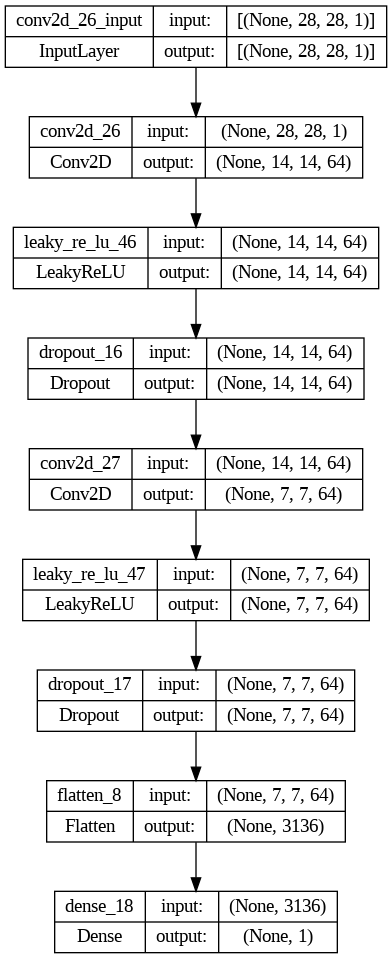

In [ ]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file=full_plot_chapter_07_path+generated_plots_folder_path+'discriminator_plot.png', show_shapes=True, show_layer_names=True)

La figura anterior permite ver la arquitectura del modelo y muestra la entrada y la salida del modelo de cada capa del modelo.  
Se puede ver el efecto de utilizar un stride 2 × 2 actúa y cómo reduce la salida de la capa de convolución pasando de una imagen de 28×28 a 14×14 y luego a 7×7, antes de que el modelo haga una predicción de salida.
Este patrón es por diseño, genera un efecto similar a cuando utilizamos capas de Pooling.

#### Carga y preparacion del conjunto de datos MNIST
A continuación cargamos el conjunto de datos MNIST y se hará un ajuste como se vio en secciones anteriores para transformar las imágenes de 28x28 a 28x28x1 para utilizar las operaciones de convolución de Keras.  
Finalmente haremos como se vio en secciones anteriores un ajuste de escala para los valores de píxeles y transformarlos de un rango de 0 a 255 a un rango de 0 a 1.  

**Listing 7.12: función para carga y ajuste del conjunto de datos MNIST**

In [ ]:
from numpy import expand_dims
from keras.datasets.mnist import load_data

# load and prepare mnist training images
def load_real_samples():
  # load mnist dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels dimension
  X = expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  #X = trainX
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X

In [ ]:
X = load_real_samples()
print(X.shape)

(60000, 28, 28, 1)


Será necesario contar con una función que permita seleccionar aleatoriamente un subconjunto de imágenes del conjunto MNIST y crea nuevas etiquetas que representen que las mismas son "reales". Ya no es relevante indicar el número al que que corresponde cada imagen sino simplemente indicar que son reales. Para ello alcanzará con crear un vector de 1s asociado al conjunto de imágenes seleccionado.   
Esto se debe a que tanto el modelo Discriminador  será entrenado a través de lotes (batches) de datos (imágenes) reales así también con imágenes generadas (falsas). El entrenamiento mediante el descenso por gradiente estocástico requiere seleccionar arbitrariamente un subcojunto de datos hasta haber seleccionado todos los elementos del conjunto y así completar lo que denominamos una época.  

A continuación se implementa la función generate_real_samples() que extrae la pareja X, Y de un subconjunto de imágenes reales de MNIST y el vector de 1s asociado.  


**Listing 7.13: Example of a function for selecting a sample of real images.**

In [ ]:
from numpy.random import rand
from numpy.random import randint
from numpy import ones

# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate ✬real✬ class labels (1)
  y = ones((n_samples, 1))
  return X, y

Ahora necesitamos una fuente de imágenes falsas. Como todavía no tenemos un modelo de generador, podemos generar imágenes compuestas de valores de píxeles aleatorios, específicamente valores de píxeles aleatorios en el rango [0,1] como nuestras imágenes reales escaladas. La función que se muestra a continuación implementa este comportamiento y genera imágenes de valores de píxeles aleatorios y su clase asociada con etiqueta de 0, para indicar que se trata de una imagen falsa.

**Listing 7.14: Función de generación de imágenes aleatorias.**

In [ ]:
from numpy.random import rand
from numpy.random import randint
from numpy import ones

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
  # generate uniform random numbers in [0,1]
  X = rand(28 * 28 * n_samples)
  # reshape into a batch of grayscale images
  X = X.reshape((n_samples, 28, 28, 1))
  # generate ✬fake✬ class labels (0)
  y = zeros((n_samples, 1))
  return X, y

####Entrenamiento del modelo   
Necesitamos una función que indique la forma de entrenamiento del Discriminador.    
Esto implica recuperar repetidamente muestras de imágenes reales y muestras de imágenes generadas y actualizar el modelo durante un número fijo de iteraciones. El modelo aprenderá a discriminar entre imágenes reales y falsas (generadas aleatoriamente). Por lo tanto, no se necesitarán muchos lotes antes de que aprenda a discriminar perfectamente.  
La función train discriminator() implementa esto, utilizando un tamaño de lote de 256 imágenes donde 128 son reales y 128 son falsas en cada iteración. Actualizamos el discriminador por separado para ejemplos reales y falsos para que podamos calcular la precisión del modelo en cada muestra antes de la actualización de parámetros. Esto da una idea de cómo se está desempeñando el modelo discriminador a lo largo del tiempo.

**Listing 7.15: Función para el entrenamiento del modelo Discriminador**

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected ✬real✬ samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
    # generate ✬fake✬ examples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    # summarize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

###Definición y entrenamiento del modelo Generador

El modelo generador es responsable de crear imágenes nuevas, falsas pero plausibles de dígitos escritos a mano. Para ello, toma un punto del espacio latente como entrada y genera una imagen cuadrada en escala de grises. El espacio latente es un espacio vectorial definido arbitrariamente de distribución gaussiana.
valores, p.e. 100 dimensiones.
Al final del entrenamiento, el espacio vectorial latente representa una
representación comprimida del espacio de salida, imágenes MNIST, que sólo el generador conoce
cómo convertirse en imágenes MNIST plausibles.
* Entradas: Punto en el espacio latente, p.e. un vector de 100 elementos de números aleatorios gaussianos.
* Salidas: Imagen cuadrada bidimensional en escala de grises de 28 × 28 píxeles con valores de píxeles en
[0,1].

####Definición del modelo

No tenemos que utilizar un vector de 100 elementos como entrada; es un número redondo y muy utilizado,
pero esperaría que 10, 50 o 500 funcionaran igual de bien.
Desarrollando un modelo de generador requiere que transformemos un vector del espacio latente con 100 dimensiones a una matriz 2D con valores de 28×28 o 784.   
Hay varias formas de lograrlo, pero hay un enfoque que ha demostrado ser eficaz en redes adversativas generativas convolucionales profundas.  
Implica dos elementos principales. La primera es una capa Densa como primera capa oculta que tiene suficientes nodos para representar una versión de baja resolución de la imagen de salida. Específicamente, una imagen de la mitad del tamaño (una un cuarto del área) de la imagen de salida sería de 14 × 14 o 196 nodos, y una imagen de un cuarto del tamaño (un octavo del área) sería de 7 × 7 o 49 nodos.      

No queremos sólo una versión de baja resolución de la imagen; queremos muchas versiones o interpretaciones paralelas de la entrada. Este es un patrón en las redes neuronales convolucionales donde tenemos muchos filtros paralelos que dan como resultado múltiples mapas de activación paralelos, llamados mapas de características, con diferentes interpretaciones de la entrada. **El modelo necesita espacio para inventar, crear o generar**. Por lo tanto, la primera capa oculta, la capa Densa, necesita suficientes nodos para múltiples versiones de baja resolución de nuestra imagen de salida, como 128. La primera capa densa será de 7x7x128.   
La siguiente gran innovación arquitectónica implica aumentar la resolución de la imagen a una versión de mayor resolución. Hay dos formas comunes de realizar este proceso de muestreo ascendente, a veces llamado deconvolución. Una forma es utilizar una capa **UpSampling2D** (como una capa de agrupación inversa) seguida de una capa **Conv2D** normal. La otra forma, quizás más moderna, es combinar estas dos operaciones en una sola capa, llamada **Conv2DTranspose**. Usaremos este último enfoque para nuestro generador.   
La capa Conv2DTranspose se puede configurar con un paso de (2 × 2) que cuadriplicará el área de los mapas de características de entrada (duplicará sus dimensiones de ancho y alto).   

Esto se puede repetir para llegar a nuestra imagen de salida de 28×28. Nuevamente, usaremos la activación LeakyReLU con una pendiente predeterminada de 0,2, lo que se considera una práctica recomendada al entrenar modelos GAN.    
La capa de salida del modelo es un Conv2D con un filtro y un tamaño de núcleo de 7 × 7 y el "mismo" relleno, diseñado para crear un mapa de características único y preservar sus dimensiones de 28 × 28 píxeles.    

Se utiliza una activación sigmoidea para garantizar que los valores de salida estén en el rango deseado de [0,1]. La siguiente función define generador() implementa esto y define el modelo del generador. El modelo del generador no está compilado y no especifica una función de pérdida ni un algoritmo de optimización.   
Esto se debe a que el generador no se entrena directamente. Aprenderemos más sobre esto en la siguiente sección.    

**Listing 7.21: Definición del modelo Generador.**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2DTranspose, Reshape, Conv2D, LeakyReLU, Dense

# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

**Listing 7.22: Defining and summarizing the generator model.**

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_10 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_20 (Conv2  (None, 14, 14, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_21 (Conv2  (None, 28, 28, 128)       262272    
 DTranspose)                                         

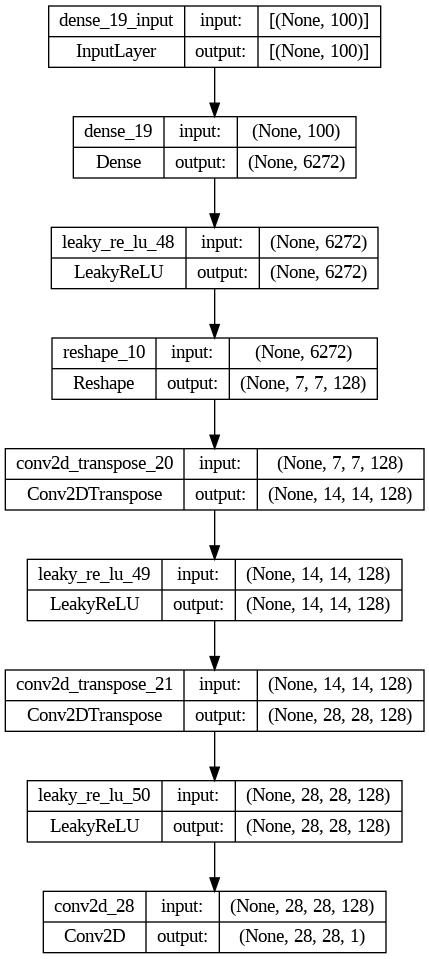

In [ ]:
from keras.utils import plot_model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file=full_plot_chapter_07_path+generated_plots_folder_path+'generator_plot.png', show_shapes=True, show_layer_names=True)

Observando la estructura del modelo anterior, se muestran las capas del modelo y su forma de salida. Podemos ver que, tal como está diseñada, la primera capa oculta tiene 6272 parámetros o 128 × 7 × 7, cuyas activaciones se remodelan en 128 mapas de características de 7 × 7. El mapa de características se actualiza a través de las dos capas Conv2DTranspose a la forma de salida deseada de 28 × 28x1.

El modelo generador sin haber sido entrenado, no es útil a efectos de nuestro objetivo. Sin embargo, ya es posible generar imágenes aleatorias y para ello es necesaria la implementación de funciones auxiliares que se presentan a continuación.  
La primera función auxiliar se refiere la generación de puntos del espacio latente, puesto que estos serán utilizados por el generador para la creación de imágenes.  Esta función genera un arreglo de números aleatorios que luego son transformados a un conjunto de un número dado de muestras (parámetro n_samples) y donde cada elemento tiene la dimensión del espacio latente.    
A continuación se presenta la implementación de esta función auxiliar.

**Listing 7.24: Example of a function for generating random points in the latent space.**

In [ ]:
from numpy.random import randn

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

A continuación, podemos utilizar los puntos generados por la función anterior y utilizarlos como entrada en el modelo generador para generar imágenes.  
Crearemos entonces una función de generación de muestras falsas a partir de un conjunto de puntos del espacio latente y luego utilizando el modelo generador para generar imágenes. Finalmente a estas imágenes se le asocia un vector de 0s para etiquetar estas imágenes como falsas.  
A continuación se presenta la implementación de esta función auxiliar.

**Listing 7.25: Example of a function for generating synthetic images using the generator model.**

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create ✬fake✬ class labels (0)
  y = zeros((n_samples, 1))
  return X, y

Ahora estamos en condiciones de implementar un algoritmo que genere imágenes a partir de un conjunto de puntos del espacio latente.
En este caso, dado que el generador no ha sido entrenado, las imágenes será arbitrarias. Pero mostraremos a continuación la rutina completa necesaria a efectos de presentar cómo se utiliza el modelo generador para generar imágenes y cómo mostrar los elementos generados.  

**Listing 7.26: Example of using the untrained generator to output random images.**

1/1 [==============================] - 0s 83ms/step


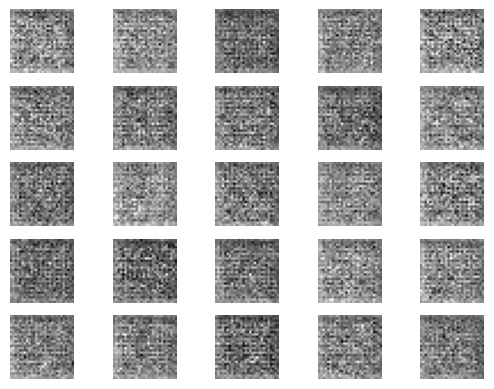

<Figure size 640x480 with 0 Axes>

In [ ]:
from numpy import zeros
from matplotlib import pyplot

# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis labels
  pyplot.axis('off')
  # plot single image
  pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()
pyplot.savefig(full_plot_chapter_07_path+generated_plots_folder_path+'generator_random_imgs_plot.png')

####Entrenamiento del modelo   

Los pesos en el modelo generador se actualizan en función del rendimiento del modelo discriminador. Cuando el discriminador es bueno para detectar muestras falsas, el generador se actualiza más, y cuando el modelo discriminador es relativamente pobre o confuso al detectar muestras falsas, el modelo del generador se actualiza menos.  

Se puede definir un nuevo modelo GAN que apile el generador
y discriminador de manera tal que el generador reciba como entrada puntos aleatorios en el espacio latente y genere muestras que se introducen directamente en el modelo discriminador. Estas muestras se clasifican y la salida de este modelo más grande se puede utilizar para actualizar los pesos del modelo del generador.
El modelo generador solo se preocupa por el desempeño del discriminador en ejemplos falsos. Por lo tanto, marcaremos todas las capas del discriminador como no entrenables cuando sea parte del modelo GAN para que no puedan actualizarse ni sobreentrenarse en ejemplos falsos. Al entrenar el generador mediante este modelo GAN lógico, hay un cambio más importante. Queremos que el discriminador piense que las muestras generadas por el generador son reales, no falsas. Por lo tanto, cuando el generador se entrena como parte del modelo GAN, marcaremos las muestras generadas como reales (clase = 1).
¿Por qué hacemos esto?   
Podemos imaginar que el discriminador clasificará entonces
las muestras generadas que no son reales (clase = 0) o tienen una baja probabilidad de ser reales (0,3 o 0,5). Al pasarle imágenes falsas etiquetadas como verdaderas, el proceso de retropropagación (backpropagation) utilizado para actualizar los pesos del modelo verá esto como un error grande y actualizará los pesos del modelo (es decir, solo los pesos en el generador) para corregir este error, lo que a su vez hará que el generador sea mejor a la hora de generar buenas muestras falsas.  


**Listing 7.27: Example of a function for defining the composite model to update the generator model via the discriminator model.**

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

**Listing 7.28: Example of defining and summarizing the composite model.**   
Defining and showing the GAN model

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 28, 28, 1)         1164289   
                                                                 
 sequential_28 (Sequential)  (None, 1)                 40705     
                                                                 
Total params: 1204994 (4.60 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 40705 (159.00 KB)
_________________________________________________________________


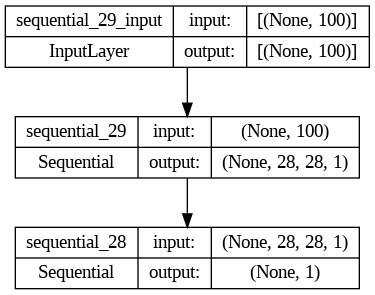

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file=full_plot_chapter_07_path+generated_plots_folder_path+'gan_plot.png', show_shapes=True, show_layer_names=True)

Entrenar el modelo compuesto implica generar un lote de puntos en el espacio latente mediante la función generar puntos latentes() en la sección anterior, y etiquetas de clase = 1 y llamar a la función train_on_batch(). La siguiente función train gan() demuestra esto, aunque es bastante simple ya que solo el generador se actualizará en cada época, dejando al discriminador con los pesos del modelo predeterminados.   
A continuación se presenta la función que realiza el entrenamiento de la GAN.  

**Listing 7.30: Example of a function for training the composite model.**

In [ ]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=1, n_batch=256):
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator✬s error
    gan_model.train_on_batch(x_gan, y_gan)

Lo que se requiere es que primero actualicemos el modelo discriminador con muestras reales y falsas, luego actualicemos el generador a través del modelo compuesto. Esto requiere combinar elementos de la función train discriminator() definida en la sección discriminator anterior y la función train gan() definida anteriormente. También requiere que enumeremos tanto las épocas como los lotes dentro de una época. La función de tren completa para actualizar el modelo discriminador y el generador (a través del modelo compuesto) se enumera a continuación.  
Hay algunos elementos a tener en cuenta en esta función de entrenamiento de modelo. Primero, la cantidad de lotes dentro de una época se define por cuántas veces el tamaño del lote se divide en el conjunto de datos de entrenamiento. Tenemos un tamaño de conjunto de datos de 60.000 muestras y un tamaño de lote de 256, por lo que, redondeando hacia abajo, hay 60000/256 o 234 lotes por época.   
El modelo discriminador se actualiza una vez por lote combinando medio lote (128) de ejemplos falsos y reales (128) en un solo lote a través de la función vstack() NumPy. Puede actualizar el discriminador con cada medio lote por separado (recomendado para conjuntos de datos más complejos), pero combinar las muestras en un solo lote será más rápido a largo plazo, especialmente cuando se entrena en hardware GPU.    
Finalmente, informamos la pérdida de cada lote. Es fundamental estar atento a la pérdida de lotes. La razón de esto es que una falla en la pérdida del discriminador indica que el modelo generador ha comenzado a generar ejemplos basura que el discriminador puede discriminar fácilmente. Es necesario supervisar la pérdida del discriminador. Se espera que oscile entre 0,5 y 0,8 por lote en este conjunto de datos. La pérdida del generador es menos crítica y puede oscilar entre 0,5 y 2 o más en este conjunto de datos. Se podría incluso intentar detectar la pérdida del discriminador, detener y luego reiniciar el proceso de entrenamiento.   
Antes de presentar la rutina de entrenamiento, es conveniente hablar del registro de información de performance a efectos de conocer cómo se comporta nuestro modelo.
En la siguiente sección se presentarán conceptos relativos a la performance y consideraciones que permitan evaluar nuestro modelo. Luego de presentados estos conceptos estaremos en condiciones de presentar el algoritmo completo de entrenamiento de nuestra GAN.  


### Evaluación de un modelo GAN

Generalmente, no existe una forma objetiva de evaluar el rendimiento de un modelo GAN. No podemos calcular una medida de error objetiva una imagen generada. Podría ser posible en el caso de imágenes MNIST porque las imágenes están muy restringidas, pero en general no es posible (todavía).
En cambio, un operador humano debe evaluar subjetivamente la calidad de las imágenes. Esto significa que no podemos saber cuándo detener el entrenamiento sin mirar ejemplos de imágenes generadas. A su vez, la naturaleza adversa del proceso de entrenamiento significa que el generador cambia después de cada lote, lo que significa que una vez que se pueden generar imágenes suficientemente buenas, la calidad subjetiva de las imágenes puede comenzar a variar, mejorar o incluso degradarse con actualizaciones posteriores.   
Hay tres formas de manejar esta compleja situación de entrenamiento.
* Evaluar periódicamente la precisión de la clasificación del discriminador en imágenes reales y falsas.   
* Generar periódicamente muchas imágenes y guardarlas en un archivo para revisión subjetiva.    
* Guarde periódicamente el modelo del generador.   

Estas tres acciones se pueden realizar al mismo tiempo para una época de entrenamiento determinada, como cada cinco o diez épocas de entrenamiento. El resultado será un modelo generador guardado para el cual tenemos una manera de evaluar subjetivamente la calidad de su salida y saber objetivamente qué tan bien se engañó al discriminador en el momento en que se guardó el modelo.

Primero, podemos definir una función de registro llamada summarize_performance() que resumirá el rendimiento del modelo discriminador. Para ello, recupera una muestra de imágenes MNIST, además de generar la misma cantidad de imágenes MNIST falsas con el modelo generador, luego evalúa la precisión de clasificación del modelo discriminador en cada muestra e informa estas puntuaciones.   
A continuación, podemos actualizar esta función de registro summarize_performance() para guardar el modelo, crear y guardar ejemplos generados por un gráfico. El modelo generador se puede guardar llamando a una función save().   
Finalmente es de interés contar con una función que registre el tiempo de entrenamiento de nuestro modelo. Esta función será utilizada dentro de la función de resumen summarize_performance(). Esta función es la denominada rec_time_exec() y fue definida como función auxiliar el comienzo del capítulo.    
Estas funciones auxiliares antes mencionadas, se presentan a continuación.  

**Listing 7.36: Example of an updated function for summarizing the performance of the GAN.**

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(plot_path, examples, epoch, n=10):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  # save plot to file
  filename = plot_path+'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

def rec_time_exec(model_path, start_time, i):
  end_time = time.time()
  elapsed_time = end_time - start_time
  elapsed_time_minutes = floor(elapsed_time) // 60
  elapsed_time_hours =  floor(elapsed_time_minutes) // 60
  elapsed_time_rem_mins = elapsed_time_minutes % 60
  elapsed_time_rem_secs = elapsed_time % 60
  time_txt_file = model_path +'training_time_%03d.txt' % (i+1)
  with open(time_txt_file, 'w') as file:
    file.write(f"Training time: {round(elapsed_time)} seconds = {elapsed_time_hours} hrs: {elapsed_time_rem_mins} mins: {elapsed_time_rem_secs} secs")

def save_into_my_models(model, model_name):
  model.save(model_name)
  print('Saving file {}'.format(model_name))

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(model_path, plot_path, start_time, epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(plot_path, x_fake, epoch)
  # save the generator model tile file
  filename = model_path+'generator_model_%03d.h5' % (epoch + 1)
  save_into_my_models(g_model, filename)
  last_filename = model_path+'generator_model_last.h5'
  save_into_my_models(g_model, last_filename)
  #g_model.save(filename)
  #g_model.save(last_filename)
  rec_time_exec(model_path, start_time, epoch)

This function can be called from the train() function based on the current epoch number,
such as every 10 epochs as it is shown in the next section.

**Example of a function for training the GAN models using summarize function.**    

It is the function presented in Listing 7.31 but adding the summarize function.   


In [ ]:
def create_local_folders(n_epochs, n_batch):
  full_model_path = full_model_chapter_07_path + 'epochs_'+ str(n_epochs) + '/batchsize_'+str(n_batch)+'/'+generated_models_folder_path
  full_plot_path = full_plot_chapter_07_path + 'epochs_'+ str(n_epochs) + '/batchsize_'+str(n_batch)+'/'+generated_plots_folder_path
  makedirs(full_model_path, exist_ok=True)
  makedirs(full_plot_path, exist_ok=True)
  return (full_model_path, full_plot_path)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  (complete_model_path, complete_plot_path) = create_local_folders(n_epochs, n_batch)
  start_time = time.time()

  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected ✬real✬ samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate ✬fake✬ examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    #evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(complete_model_path, complete_plot_path, start_time, i, g_model, d_model, dataset, latent_dim)
  return (complete_model_path, complete_plot_path)

Invocación al algoritmo de entrenamiento del modelo GAN

In [ ]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from math import floor
import time

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
(complete_model_path, complete_plot_path) = train(g_model, d_model, gan_model, dataset, latent_dim)


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step
>22, 179/234, d=0.683, g=0.689
4/4 [==============================] - 0s 4ms/step
>22, 180/234, d=0.682, g=0.672
4/4 [==============================] - 0s 4ms/step
>22, 181/234, d=0.685, g=0.808
4/4 [==============================] - 0s 4ms/step
>22, 182/234, d=0.704, g=0.779
4/4 [==============================] - 0s 3ms/step
>22, 183/234, d=0.684, g=0.676
4/4 [==============================] - 0s 4ms/step
>22, 184/234, d=0.680, g=0.705
4/4 [==============================] - 0s 4ms/step
>22, 185/234, d=0.686, g=0.717
4/4 [==============================] - 0s 4ms/step
>22, 186/234, d=0.682, g=0.630
4/4 [==============================] - 0s 4ms/step
>22, 187/234, d=0.697, g=0.805
4/4 [==============================] - 0s 4ms/step
>22, 188/234, d=0.688, g=0.683
4/4 [==============================] - 0s 4ms/step
>22, 189/234, d=0.682, g=0.727
4/4 [==============================] - 0s 4ms/s

### Código completo del model DCGAN para MNIGST
  


A continuación se presenta el código completo incluyendo las funciones auxiliares a efectos de facilitar la ejecución completa del ejercicio.  

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
my_folder_path = '/content/gdrive/MyDrive/MySavedModels/'
generated_plots_folder_path = 'GeneratedPlots/'
generated_models_folder_path = 'GeneratedModels/'
chapter_07_path = 'Chapter_07/'

full_model_chapter_07_path = my_folder_path+chapter_07_path
full_plot_chapter_07_path = my_folder_path+chapter_07_path

In [ ]:
from os import makedirs

# make folder for results
makedirs(full_model_chapter_07_path, exist_ok=True)
makedirs(full_plot_chapter_07_path, exist_ok=True)

In [ ]:
# Calculate the number of steps of training
n_samples = 60000
batch_size = 256
bat_per_epo = n_samples // batch_size
epochs = 100
total_steps = bat_per_epo * epochs

print(total_steps)

23400


In [ ]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from math import floor
import time

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare mnist training images
def load_real_samples():
  # load mnist dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels dimension
  X = expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  #X = trainX
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X

# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate ✬real✬ class labels (1)
  y = ones((n_samples, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create ✬fake✬ class labels (0)
  y = zeros((n_samples, 1))
  return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(plot_path, examples, epoch, n=10):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  # save plot to file
  filename = plot_path+'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

def rec_time_exec(model_path, start_time, i):
  end_time = time.time()
  elapsed_time = end_time - start_time
  elapsed_time_minutes = floor(elapsed_time) // 60
  elapsed_time_hours =  floor(elapsed_time_minutes) // 60
  elapsed_time_rem_mins = elapsed_time_minutes % 60
  elapsed_time_rem_secs = elapsed_time % 60
  time_txt_file = model_path +'training_time_%03d.txt' % (i+1)
  with open(time_txt_file, 'w') as file:
    file.write(f"Training time: {round(elapsed_time)} seconds = {elapsed_time_hours} hrs: {elapsed_time_rem_mins} mins: {elapsed_time_rem_secs} secs")

def save_into_my_models(model, model_name):
  model.save(model_name)
  print('Saving file {}'.format(model_name))

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(model_path, plot_path, start_time, epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(plot_path, x_fake, epoch)
  # save the generator model tile file
  filename = model_path+'generator_model_%03d.h5' % (epoch + 1)
  save_into_my_models(g_model, filename)
  last_filename = model_path+'generator_model_last.h5'
  save_into_my_models(g_model, last_filename)
  #g_model.save(filename)
  #g_model.save(last_filename)
  rec_time_exec(model_path, start_time, epoch)

def create_local_folders(n_epochs, n_batch):
  full_model_path = full_model_chapter_07_path + 'epochs_'+ str(n_epochs) + '/batchsize_'+str(n_batch)+'/'+generated_models_folder_path
  full_plot_path = full_plot_chapter_07_path + 'epochs_'+ str(n_epochs) + '/batchsize_'+str(n_batch)+'/'+generated_plots_folder_path
  makedirs(full_model_path, exist_ok=True)
  makedirs(full_plot_path, exist_ok=True)
  return (full_model_path, full_plot_path)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  (complete_model_path, complete_plot_path) = create_local_folders(n_epochs, n_batch)
  start_time = time.time()

  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected ✬real✬ samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate ✬fake✬ examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    #evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(complete_model_path, complete_plot_path, start_time, i, g_model, d_model, dataset, latent_dim, 100, 256)
  return (complete_model_path, complete_plot_path)

# size of the latent space
latent_dim = 100
# create the discriminator
#d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
(complete_model_path, complete_plot_path) = train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 1s 150ms/step
>1, 1/234, d=0.704, g=0.786
4/4 [==============================] - 1s 148ms/step
>1, 2/234, d=0.663, g=0.890
4/4 [==============================] - 1s 152ms/step
>1, 3/234, d=0.630, g=0.974
4/4 [==============================] - 1s 153ms/step
>1, 4/234, d=0.626, g=0.929
4/4 [==============================] - 1s 152ms/step
>1, 5/234, d=0.653, g=0.773
4/4 [==============================] - 1s 157ms/step
>1, 6/234, d=0.641, g=0.701
4/4 [==============================] - 1s 212ms/step
>1, 7/234, d=0.602, g=0.692
4/4 [==============================] - 1s 150ms/step
>1, 8/234, d=0.559, g=0.695
4/4 [==============================] - 1s 240ms/step
>1, 9/234, d=0.518, g=0.698
4/4 [==============================] - 1s 150ms/step
>1, 10/234, d=0.471, g=0.702
4/4 [==============================] - 1s 241ms/step
>1, 11/234, d=0.427, g=0.709
4/4 [==============================] - 1s 150ms/step
>1, 12/234, d=0.405, g=0.718
4/4 [====================

### Cómo utilizar el Generador del modelo

Una vez entrenado nuestro modelo, simplemente podemos utilizar directamente el Generador pasando un punto arbitrario del espacio latente.  
A continuación presentamos el código que muestra la selección de un punto del espacio latente y la generación de la imagen creada por el Generador.  

In [ ]:
complete_plot_path = full_model_chapter_07_path + 'epochs_100/'+'batchsize_256/GeneratedPlots/'
complete_model_path = full_model_chapter_07_path + 'epochs_100/'+'batchsize_256/GeneratedModels/'

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  pyplot.show()
  pyplot.savefig(complete_plot_path+'Generated_Img_GrayScale.png')

In [ ]:
# load model
model = load_model(complete_model_path+'generator_model_last.h5')
# generate images
latent_points = generate_latent_points(100, 36)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 6)

OSError: No file or directory found at /content/gdrive/MyDrive/MySavedModels/Chapter_07/epochs_100/batchsize_256/GeneratedModels/generator_model_last.h5

A continuación se presenta un algoritmo que permite generar aleatoriamente distintas imagenes. Se elije arbitrariamente un punto del espacio latente y se genera una imagen.  

1/1 [==============================] - 0s 100ms/step


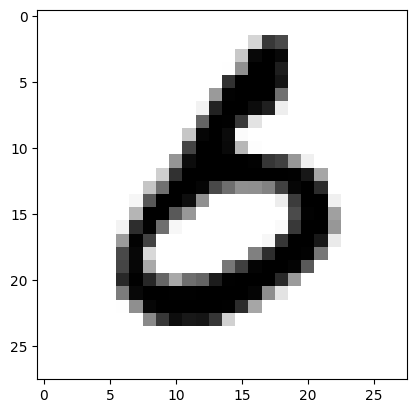

In [ ]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model(full_model_chapter_07_path+'generator_model_last.h5')
# all 0s
#vector = asarray([[0.71 for _ in range(100)]])
latent_points = generate_latent_points(100, 25)
vector = asarray([latent_points[0]])
# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

#Extensiones

Esta sección enumera algunas ideas para mejorar el modelo GAN antes presentado y que se recomienda explorar:
* **Activación y escalamiento de TanH**. Actualice el ejemplo para usar la función de activación de Tanh en el generador y escale todos los valores de píxeles al rango [-1, 1].
* **Cambiar espacio latente**. Actualice el ejemplo para utilizar un espacio latente mayor o menor y compare la calidad de los resultados y la velocidad del entrenamiento.
* Normalización por lotes (Batch Normalization). Actualice el discriminador y/o el generador para hacer uso de la normalización por lotes, recomendado para modelos DCGAN.
* **Suavizado de etiquetas**. Actualice el ejemplo para utilizar el suavizado de etiquetas unilaterales al entrenar el discriminador, cambie específicamente la etiqueta de destino de los ejemplos reales de 1,0 a 0,9 y revise los efectos sobre la calidad de la imagen y la velocidad del entrenamiento.
* **Configuración del modelo**. Actualice la configuración del modelo para utilizar modelos discriminadores y/o generadores más profundos o más superficiales, tal vez experimente con las capas UpSampling2D en el generador